# COVID-19 Cases vs. Tweets

The goal is to analyse how the number of Tweets regarding COVID-19 correlates with the case numbers in Germany. Due to the restrictions of the Twitter API (only limited number of tweets can be searched), prominent Twitter accounts of German Politicians will be used instead of statistics of the general population.

This analysis could easily be expanded for other countries and their politicians, or a more general population using the geolocation of tweets.

DISCLAIMER: This notebook will not run through, unless you have the correct keys saved in keys.txt and mongodb.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For COVID data
import pandas as pd

# For Twitter Data
import json
import tweepy
from pymongo import MongoClient

# For Tweet Analysis
from collections import Counter
import operator

## COVID-19 Data

The data was last downloaded from Our World in Data on December 31st, 2020 and is updated daily. The data was saved in a csv file. Alternatively, they provide code in a github to automatically pull the newest data.

Source: https://ourworldindata.org/coronavirus/country/germany?country=~DEU, https://github.com/owid/covid-19-data

In [2]:
data = pd.read_csv('data/owid-covid-data.csv', header=0)
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [3]:
# Check whether data format should be converted --> Not necessary
# data.dtypes
# data.memory_usage(index=False)
# data.astype('category').memory_usage(index=False)

In [4]:
# Filter data for Germany
data_ger = data.loc[data['location'] == 'Germany']
data_ger.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
19415,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19416,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19417,DEU,Europe,Germany,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19418,DEU,Europe,Germany,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19419,DEU,Europe,Germany,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936


### Analyze COVID-19 Germany Data

In [5]:
def makePlot(data, title, xlabel, ylabel):
    """Function to create plots for the COVID-19 data

    Parameters
    ----------
    data : array, first column contains the dates, second column contains the data
    title : str
    xlabel : str
    ylabel : str
    """
    data_copy = data.copy()
    
    # Create Figure
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(1, 12)
    ax.grid(True)

    # Convert dates
    data_copy[:,0] = [int(d[5:7])-1+int(d[-2:])/32 for d in data_copy[:,0]]

    # Resort
    data_copy = data_copy[data_copy[:,0].argsort()]

    # Plot
    ax.plot(data_copy[:,0], data_copy[:,1])
    plt.show()

First, we will take a look at the number of new daily cases and new daily deaths, including some of their general statistics. The goal is to find critical dates, on which attention around the virus should be high.

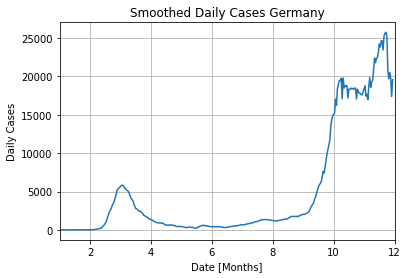

In [6]:
new_cases_smoothed = data_ger[['date','new_cases_smoothed']].values
makePlot(new_cases_smoothed, 'Smoothed Daily Cases Germany', 'Date [Months]', 'Daily Cases')

In [7]:
cases_stats = data_ger['new_cases_smoothed'].describe()
print(cases_stats)

count      334.000000
mean      4993.198428
std       7339.502736
min          0.000000
25%        450.357250
50%       1284.643000
75%       5291.250250
max      25757.000000
Name: new_cases_smoothed, dtype: float64


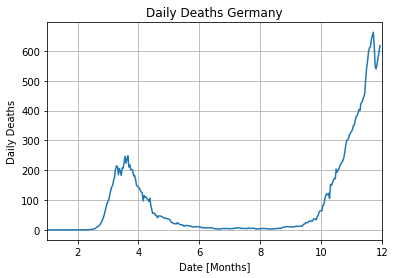

In [8]:
new_deaths_smoothed = data_ger[['date','new_deaths_smoothed']].values
makePlot(new_deaths_smoothed, 'Daily Deaths Germany', 'Date [Months]', 'Daily Deaths')

In [9]:
deaths_stats = data_ger['new_deaths_smoothed'].describe()
print(deaths_stats)

count    334.000000
mean      92.298982
std      150.679719
min        0.000000
25%        4.606750
50%       14.357000
75%      122.357000
max      662.286000
Name: new_deaths_smoothed, dtype: float64


### Velocity and Acceleration of Infection

It is important to look at the changes of the Infections and Deaths, as this is a indication of where the future cases are going. E.g. if the number of cases are rising, it is more important to pay attention to the spread.

In [10]:
def rateOfChange(data):
    """Function to create plots for the COVID-19 data

    Parameters
    ----------
    data : array, first column contains the dates, second column contains the data

    Output
    ------
    velocity : array, N-1 entries
    acceleration : array, N-2 entries
    """

    # Get velocity
    vel = np.array([(data[idx,0],data[idx+1,1]-value) 
        for idx,value in enumerate(data[:-1,1])], dtype=object)

    # Get acceleration
    acc = np.array([(data[idx,0],vel[idx+1,1]-value) 
        for idx,value in enumerate(vel[:-1,1])], dtype=object)

    return vel, acc

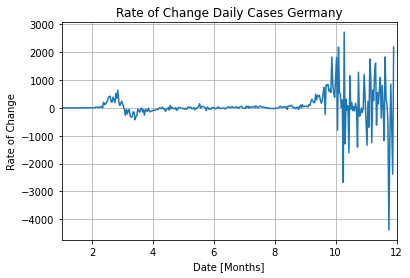

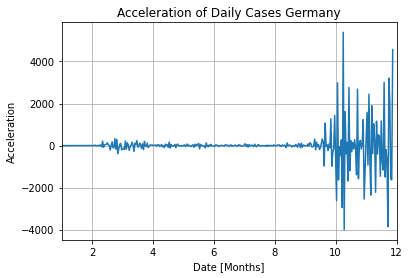

In [11]:
vel_cases, acc_cases = rateOfChange(new_cases_smoothed)
vel_deaths, acc_deaths = rateOfChange(new_deaths_smoothed)
makePlot(vel_cases, 'Rate of Change Daily Cases Germany', 'Date [Months]', 'Rate of Change')
makePlot(acc_cases, 'Acceleration of Daily Cases Germany', 'Date [Months]', 'Acceleration')

Because the velocities and accelerations are quite noisy, these should be smoothed. For this I will use a seven day running average.

In [12]:
def sevenDayAverage(data):
    """Smooth using the seven day average"""
    smooth = data.copy()
    for idx in range(len(data)):
        try:
            smooth[idx,1] = np.mean(data[idx-3:idx+3,1])
        except ZeroDivisionError:
            smooth[idx,1] = np.nan
        
    return smooth

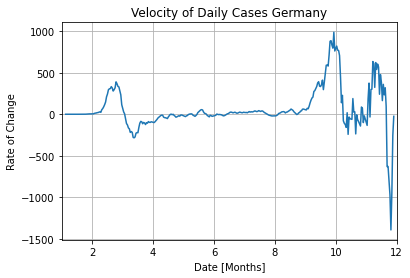

In [13]:
vel_cases_smoothed = sevenDayAverage(vel_cases)
makePlot(vel_cases_smoothed, 'Velocity of Daily Cases Germany', 'Date [Months]', 'Rate of Change')

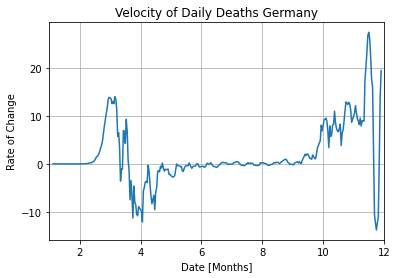

In [14]:
vel_deaths_smoothed = sevenDayAverage(vel_deaths)
makePlot(vel_deaths_smoothed, 'Velocity of Daily Deaths Germany', 'Date [Months]', 'Rate of Change')

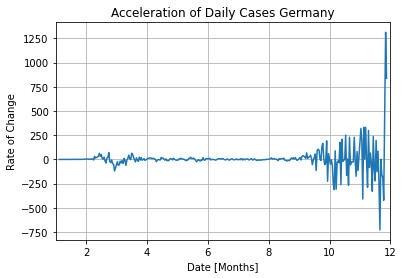

In [15]:
acc_cases_smoothed = sevenDayAverage(acc_cases)
makePlot(acc_cases_smoothed, 'Acceleration of Daily Cases Germany', 'Date [Months]', 'Rate of Change')

### Dates of high importance

Using the daily number, velocity and acceleration of the COVID cases and deaths, we can filter for important dates regarding the spread of COVID-19 in Germany. The filter values are based off of the statistic from earlier, particularly the mean values.

The rate of deaths is not used, since seems that the media has focused more on the changes in the number of cases. This shall also be the focus here.

In [16]:
# Parameters
MIN_DAILY_CASES = 2000
MIN_DAILY_DEATHS = 25
MIN_VELOCITY = 145
MIN_ACCELERATION = 15

In [17]:
# Get days with high values
mask = (data_ger['new_cases_smoothed'] > MIN_DAILY_CASES) | \
    (data_ger['new_deaths_smoothed'] > MIN_DAILY_DEATHS)

high_dates = data_ger['date'].loc[mask].values

print("There were " + str(len(high_dates)) + " dates that had new daily case numbers over " + str(MIN_DAILY_CASES) + " and new daily deaths over " + str(MIN_DAILY_DEATHS) + ".")

There were 166 dates that had new daily case numbers over 2000 and new daily deaths over 25.


In [18]:
# Get days with high rates
rate_mask = (vel_cases_smoothed[:,1] > MIN_VELOCITY)[:-1] & \
    (acc_cases_smoothed[:,1] > MIN_ACCELERATION)

rate_dates = acc_cases_smoothed[rate_mask,0]

print("There were " + str(len(rate_dates)) + " dates that had a velocity of daily case numbers over " + str(MIN_VELOCITY) + " and acceleration over " + str(MIN_ACCELERATION) + ".\nHowever, the acceleration just adds noise, so only the velocity will be used.")

There were 28 dates that had a velocity of daily case numbers over 145 and acceleration over 15.
However, the acceleration just adds noise, so only the velocity will be used.


In [19]:
# Get days with high rates
rate_mask = (vel_cases_smoothed[:,1] > MIN_VELOCITY)[:-1]

rate_dates = acc_cases_smoothed[rate_mask,0]

print("There were " + str(len(rate_dates)) + " dates that had a velocity of daily case numbers over " + str(MIN_VELOCITY) + ".")

There were 68 dates that had a velocity of daily case numbers over 145.


In [20]:
# Find matching dates
crit_dates_idx = [date in rate_dates for date in high_dates]
critical_dates = high_dates[crit_dates_idx]

print("Combing the dates, a total of " + str(len(critical_dates)) + " critical dates were found.\n Let\'s look at the critical dates overlayed onto the earlier graphs as a sanity check.'")

Combing the dates, a total of 62 critical dates were found.
 Let's look at the critical dates overlayed onto the earlier graphs as a sanity check.'


In [21]:
def show_critical_dates(critical_dates, new_daily_cases, title, xlabel, ylabel):
    """Function to create plots for the COVID-19 data

    Parameters
    ----------
    data : array, first column contains the dates, second column contains the data
    title : str
    xlabel : str
    ylabel : str
    """

    # Make copies
    critical_dates_cp = critical_dates.copy()
    new_daily_cases_cp = new_daily_cases.copy()

    # Convert
    critical_dates_cp = [int(d[5:7])-1+int(d[-2:])/32 for d in critical_dates_cp]
    new_daily_cases_cp[:,0] = [int(d[5:7])-1+int(d[-2:])/32 for d in new_daily_cases_cp[:,0]]

    # Create Matrix with all Dates
    data = np.array((np.arange(1,12,1/32), np.newaxis), dtype=object)

    # Add critical dates to Matrix
    data[1] = [d in critical_dates_cp for d in data[0]]
    assert(np.sum(data[1])==len(critical_dates_cp))
    
    # Create Figure
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(1, 12)
    ax.grid(True)

    # Plot
    ax.plot(new_daily_cases_cp[:,0], new_daily_cases_cp[:,1], label=ylabel)

    background = np.max(new_daily_cases_cp[:,1])*np.ones(data[0].shape)
    ax.bar(data[0][data[1]], background[data[1]], color='red', width =1/32, label="Critical Dates")
    plt.legend(loc='best')
    plt.show()

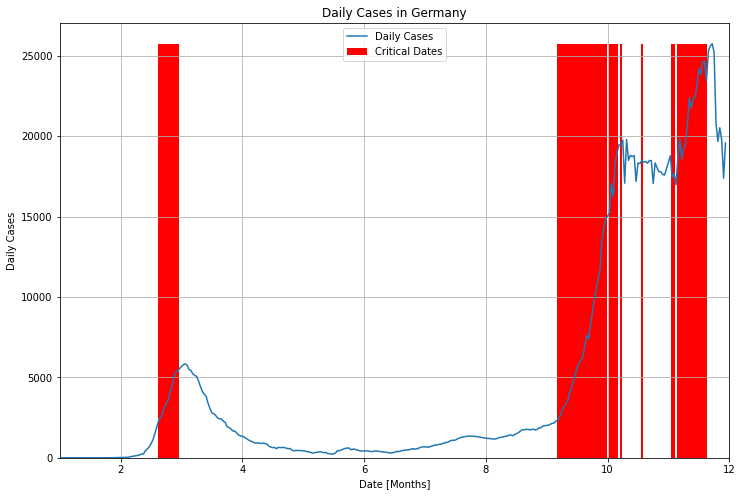

In [22]:
show_critical_dates(critical_dates, new_cases_smoothed, 'Daily Cases in Germany', 'Date [Months]', 'Daily Cases')

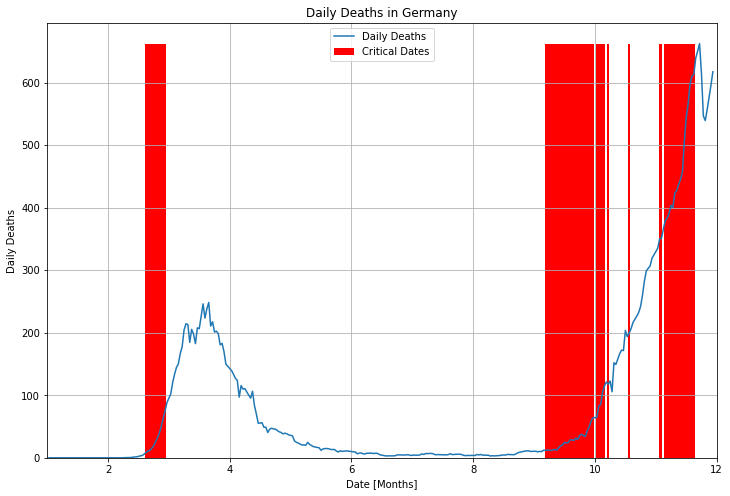

In [23]:
show_critical_dates(critical_dates, new_deaths_smoothed, 'Daily Deaths in Germany', 'Date [Months]', 'Daily Deaths')

The critical dates seem to make sense. We will now move on to collecting the Tweets and doing preliminary analyses, before combining the data.

## Twitter Data

Using the TwitterAPI, Tweets could be collected and used as a database to find correlations between the general publics frequency of discussing COVID-19 and the case numbers. For this, there are 2 main options:
  * Stream Tweets using Hastags
  * Searching for Tweets in the historical database using Hastags

Both options were implemented and can be found in get_tweets.py, however, due to the restrictions to the number of tweets that can be downloaded, and the fact that I didn't start streaming at the beginning of the pandemic another option must be used.

Using prominent politicians in Germany as a substitute, similar correlations may be found. Of course, this adds another layer to the analysis, since politicians have other motivations, but by using a variety of politicians this may even out.

First, we must select the most popluar politicians in Germany.

### Ranking of the ten most popular German politicians on social networks in July 2020

<img src="images/german_politicians_statista.PNG" alt="Graph" style="width: 500px;"/>

source: https://www.statista.com/statistics/446360/social-media-ranking-of-the-most-popular-politicians-germany/


### Twitter Handles:
  * N/A
  * @sebastiankurz
  * @martinschulz
  * @SWagenknecht
  * N/A
  * @GregorGysi
  * @JunckerEU
  * @MartinSonneborn
  * @c_lindner
  * @nicosemsrott


The trouble is that the most popular figure, Bundeskanzlerin Merkel, does not have a twitter account. Furthermore, the second on the list is Sebastian Kurz, an Austrian politician. Regardslessly, the tweets will be collected and analyzed. If necessary, the list can be expanded or adapted.

In [24]:
# Users
USERS = ['sebastiankurz','martinschulz','SWagenknecht','GregorGysi',
    'JunckerEU','MartinSonneborn','c_lindner','nicosemsrott']

# Hashtags
HASHTAGS = ['corona','coronavirus','coronakrise','covid','covid19']

### Access Twitter API

Using a developer account, tweets can be read using the Twitter API. For this the developers token should be saved in a text file.

In [25]:
# Twitter Access
CONSUMER_KEY = None
CONSUMER_SECRET = None
ACCESS_TOKEN = None
ACCESS_TOKEN_SECRET = None

with open('keys.txt') as keys:
    CONSUMER_KEY = keys.readline().replace('\n', '')
    CONSUMER_SECRET = keys.readline().replace('\n', '')
    ACCESS_TOKEN = keys.readline().replace('\n', '')
    ACCESS_TOKEN_SECRET = keys.readline().replace('\n', '')

# Login
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

### Connect to MongoDB

I will use MongoDB to store the Tweets, since they are semi-structured data. I have created a free Cluster in the MongoDB Cloud for this. Please approach me, if you would like the keys.

In [26]:
# Connect to mongoDB
MONGO_DB_NAME = None
MONGO_PASSWORD = None

with open('mongodb.txt') as keys:
    MONGO_DB_NAME = keys.readline().replace('\n', '')
    MONGO_PASSWORD = keys.readline().replace('\n', '')

try:
    # Connect to client
    client = MongoClient('mongodb+srv://kevinhuestis:' + 
        str(MONGO_PASSWORD) + '@cluster0.ahwbn.mongodb.net/' + 
        str(MONGO_DB_NAME) + '?retryWrites=true&w=majority')
    
    # Use test database
    db = client.test

    # Collection
    col = db.userTweets
    
except Exception as e:
    print(e)

Using the Cursor Class from Tweepy, all Tweets from a specific user can be loaded into MongoDB.

In [27]:
class SearchTwitter():
    """Search for Tweets using the api"""

    def __init__(self, api, db, col):
        self.api = api
        self.db = db
        self.col = col
        self.START_DATE = 2020


    def search_by_hashtag(self, words):
        """Search by Hashtag"""
        for data in api.search(q=words):
            try:      
                # Decode the Tweet
                datajson = json.loads(data)
                
                # Insert the data into the mongoDB
                self.col.insert_one(datajson)

            except Exception as e:
                print(e)  

    
    def search_by_user(self, user):
        """ Search by User"""
        for status in self.limit_handled(tweepy.Cursor(api.user_timeline, id=user).items()):

            # Only search for tweets in 2020
            if status.created_at.year < self.START_DATE:
                break

            try:      
                # Decode the Tweet
                datadump = json.dumps(status._json)
                datajson = json.loads(datadump)
                
                # Insert the data into the mongoDB
                self.col.insert_one(datajson)

            except Exception as e:
                print(e)     


    @classmethod
    def limit_handled(self, cursor):
        """Handles Twitter limit"""
        while True:
            try:
                yield cursor.next()
            except tweepy.RateLimitError:
                time.sleep(15 * 60)
            except Exception as e:
                print(e)

In [28]:
searcher = SearchTwitter(api, db, col)

for user in USERS:
    searcher.search_by_user(user)
    print("Finished collecting Tweets from user @" + user)

Finished collecting Tweets from user @sebastiankurz
Finished collecting Tweets from user @martinschulz
Finished collecting Tweets from user @SWagenknecht
Finished collecting Tweets from user @GregorGysi
Finished collecting Tweets from user @JunckerEU
Finished collecting Tweets from user @MartinSonneborn
Finished collecting Tweets from user @c_lindner
Finished collecting Tweets from user @nicosemsrott


## Tweet analysis

In [29]:
# Retrieve Tweets
my_tweets = col.find({},{'lang':1, '_id':0, 'text':1, 'created_at':1,
    'entities.hashtags':1, 'in_reply_to_status_id':1, 'is_quote_status':1,
    'retweeted_status':1, 'user.screen_name':1})

numTweets = col.count()

print("A total of " + str(numTweets) + " Tweets from " + str(len(USERS)) + " users were collected.")

A total of 5898 Tweets from 8 users were collected.


In [30]:
def plotTweetTypes(my_tweets):
    """Plot how many of them are retweets, replies, quotations or original tweets
    
    Credit: Provided by the Professor
    """
    my_tweets.rewind() #Reset cursor
    retweets = replies = quotations = originals = 0
    for t in my_tweets:
        if t.get('retweeted_status') is not None:
            retweets=retweets+1
        elif t['is_quote_status'] is not False:
            quotations = quotations+1
        elif t.get('in_reply_to_status_id') is not None:
            replies = replies+1
        else:
            originals = originals+1

    # ----------- Pie Chart ------------------~------
    labels = 'Original Content', 'Retweets', 'Quotations', 'Replies'
    sizes = [originals, retweets, quotations, replies]
    frequencies = [x/numTweets for x in sizes]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    explode = (0.1, 0, 0, 0) # explode 1st slice
    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Percentage of Tweets depending on how the content is generated')
    plt.show()

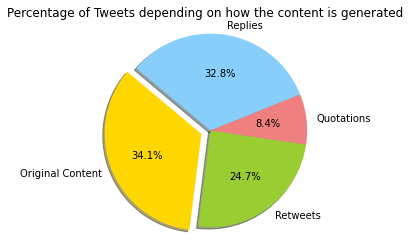

In [31]:
plotTweetTypes(my_tweets)

This chart is not particularly important in our case, but it shows that the greatest share of Tweets are Original Content.

In [32]:
def plotHashtags(my_tweets):
    """Plot common hashtags
        
    Credit: Provided by the Professor
    """
    my_tweets.rewind() #Reset cursor
    hashList = []
    for t in my_tweets:
        for e in t['entities']['hashtags']:
            h = e['text']
            hashList.append(h)
            
    D = Counter(hashList)
    subset = dict(D.most_common(15))
    sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

    # ----------- Horizontal Bar Plot ------------------------
    pos = range(len(sorted_subset))
    plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color =
    'yellowgreen')
    plt.yticks(pos, [val[0] for val in sorted_subset])
    plt.tight_layout()
    plt.title('Top 15 of hashtags captured')
    plt.show()

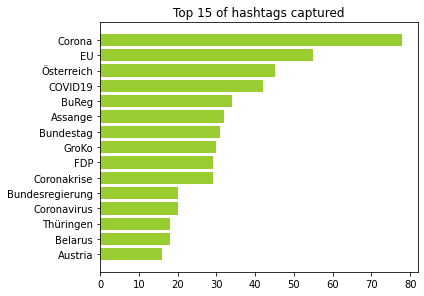

In [33]:
plotHashtags(my_tweets)

Looking at the most common hashtags, we can assure that no important hashtag will be missed. For example, the hashtag #Coronakrise, German for corona crisis, would have been missed without this analysis. 

In [34]:
def covidHashtags(my_tweets):
    """Count number of tweets regaring COVID-19 daily

    Parameters
    ----------
    my_tweets, array

    Output
    ---------
    array, includes dates and counts
    """
    my_tweets.rewind() #Reset cursor
    hashList = []
    for t in my_tweets:
        for e in t['entities']['hashtags']:
            # Filter by hashtag
            if e['text'].lower() in HASHTAGS:
                # Convert date to YYYY-MM-DD
                tmp_Month = t['created_at'][4:7]
                tmp_DD = t['created_at'][8:10]
                tmp_YYYY = t['created_at'][-4:]
                # Convert month and append
                if tmp_Month=='Jan':
                    hashList.append(tmp_YYYY + "-01-" + tmp_DD)
                elif tmp_Month=='Feb':
                    hashList.append(tmp_YYYY + "-02-" + tmp_DD)
                elif tmp_Month=='Mar':
                    hashList.append(tmp_YYYY + "-03-" + tmp_DD)
                elif tmp_Month=='Apr':
                    hashList.append(tmp_YYYY + "-04-" + tmp_DD)
                elif tmp_Month=='May':
                    hashList.append(tmp_YYYY + "-05-" + tmp_DD)
                elif tmp_Month=='Jun':
                    hashList.append(tmp_YYYY + "-06-" + tmp_DD)
                elif tmp_Month=='Jul':
                    hashList.append(tmp_YYYY + "-07-" + tmp_DD)
                elif tmp_Month=='Aug':
                    hashList.append(tmp_YYYY + "-08-" + tmp_DD)
                elif tmp_Month=='Sep':
                    hashList.append(tmp_YYYY + "-09-" + tmp_DD)
                elif tmp_Month=='Oct':
                    hashList.append(tmp_YYYY + "-10-" + tmp_DD)
                elif tmp_Month=='Nov':
                    hashList.append(tmp_YYYY + "-11-" + tmp_DD)
                elif tmp_Month=='Dec':
                    hashList.append(tmp_YYYY + "-12-" + tmp_DD)
                else:
                    raise Exception("Invalid Month: " + str(tmp_Month))
                # So each tweet is only added once
                break
    
    # Convert to counts
    date_count = Counter(hashList)

    # Convert to array
    dictList = [np.array((key, value),dtype=object) for key, value in date_count.items()]
            
    return np.array(dictList)

In [35]:
# Plot Hashtags
covid_tweet_dates = covidHashtags(my_tweets)
num_covid_tweets = np.sum(covid_tweet_dates[:,1])

print("There are " + str(num_covid_tweets) + " of " + str(numTweets) + " tweets with the hastags related to COVID-19.")

There are 192 of 5898 tweets with the hastags related to COVID-19.


## Combine Data

Now we can overlay the critical dates with the tweet frequency and analyze the correlation.

In [36]:
def compareData(critical_dates, covid_tweet_dates, title, xlabel, ylabel):
    """Function to create plots for the COVID-19 data

    Parameters
    ----------
    data : array, first column contains the dates, second column contains the data
    title : str
    xlabel : str
    ylabel : str
    """
    # Make copies
    critical_dates_cp = critical_dates.copy()
    covid_tweet_dates_cp = covid_tweet_dates.copy()

    # Convert
    critical_dates_cp = [int(d[5:7])-1+int(d[-2:])/32 for d in critical_dates_cp]
    covid_tweet_dates_cp[:,0] = [int(d[5:7])-1+int(d[-2:])/32 for d in covid_tweet_dates_cp[:,0]]

    # Create Matrix with all Dates
    data = np.array((np.arange(1,12,1/32), np.newaxis, np.newaxis), dtype=object)

    # Add counts to Matrix
    data[1] = np.zeros(data[0].shape)
    for d, cnt in covid_tweet_dates_cp:
        data[1][data[0]==d] = cnt

    # Add critical dates to Matrix
    data[2] = [d in critical_dates_cp for d in data[0]]
    assert(np.sum(data[2])==len(critical_dates_cp))
    
    # Create Figure
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(1, 12)
    ax.grid(True)

    # Plot
    background = np.max(data[1])*np.ones(data[1].shape)
    ax.bar(data[0][data[2]], background[data[2]], color='red', width =1/32, label="Critical Dates")
    ax.bar(data[0], data[1], color='blue', width =1/32, label="Frequency of Tweets")
    plt.legend(loc='best')
    plt.show()

    return data

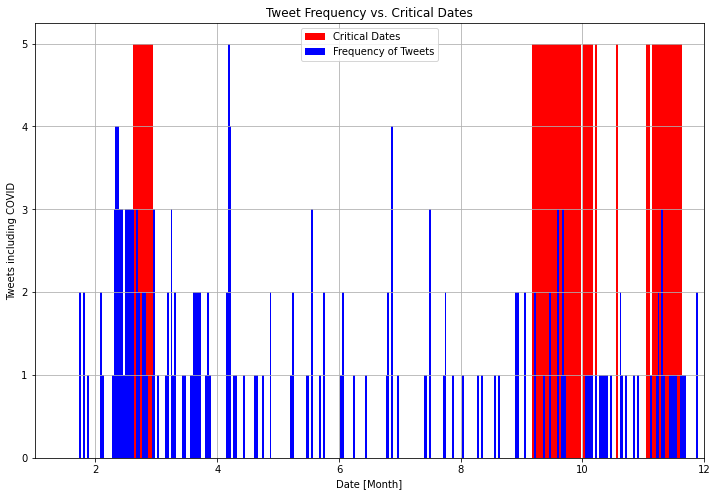

In [37]:
data = compareData(critical_dates, covid_tweet_dates, 'Tweet Frequency vs. Critical Dates', 'Date [Month]', 'Tweets including COVID')

In [38]:
num_crit_tweets = int(np.sum(data[1][data[2]]))

print("Out of the " + str(num_covid_tweets) + " tweets with the COVID-19 Hashtags, " + str(num_crit_tweets) + " tweets (" + str(round(100*num_crit_tweets/num_covid_tweets,2)) + " percent) are within criticial dates.\nCritical dates make up " + str(round(100*np.sum(data[2])/len(data[2]),2)) + " percent of days of the year.")

Out of the 192 tweets with the COVID-19 Hashtags, 44 tweets (22.92 percent) are within criticial dates.
Critical dates make up 17.61 percent of days of the year.


So, it seems that the number of tweets regarding COVID-19 slightly correlate with the critical dates, since a the percentage of the tweets in these dates (23 percent) is higher than the percent of cricital dates in the year (18 percent). Due to the importance of these days, one would suspect however, that the correlation should be even higher than this.

However, this sample size is quite small. Because of this, I will try to collect more tweets and redo the same analysis. 

### Alternative accounts:
We will add some popular news outlets and celebreties to gather more tweets.

Source: https://www.twitter-ranking.de/

News Agencies:
  * tagesschau
  * derspiegel
  * zeitonline
  * spiegel_eil
  * BILD
  * SZ
  * welt
  * sternde
  * ZDF
  * ZDFheute
  * faznet

Celebreties:
  * ToniKroos
  * heidiklum
  * janboehm
  * officiallyjoko


In [39]:
ALT_USERS = ['tagesschau', 'derspiegel', 'zeitonline', 'spiegel_eil', 'BILD', 
    'SZ', 'welt', 'sternde', 'ZDF', 'ZDFheute', 'faznet', 'ToniKroos',
    'heidiklum', 'janboehm', 'officiallyjoko']

In [40]:
# New collection
col = db.altUserTweets

searcher = SearchTwitter(api, db, col)

for user in ALT_USERS:
    searcher.search_by_user(user)
    print("Finished collecting Tweets from user @" + user)

Finished collecting Tweets from user @tagesschau
Finished collecting Tweets from user @derspiegel
Finished collecting Tweets from user @zeitonline
Finished collecting Tweets from user @spiegel_eil
Finished collecting Tweets from user @BILD
Finished collecting Tweets from user @SZ
Finished collecting Tweets from user @welt
Finished collecting Tweets from user @sternde
Finished collecting Tweets from user @ZDF
Finished collecting Tweets from user @ZDFheute
Finished collecting Tweets from user @faznet
Finished collecting Tweets from user @ToniKroos
Finished collecting Tweets from user @heidiklum
Finished collecting Tweets from user @janboehm
Finished collecting Tweets from user @officiallyjoko


In [41]:
# Retrieve Tweets
alt_tweets = col.find({},{'lang':1, '_id':0, 'text':1, 'created_at':1,
    'entities.hashtags':1, 'in_reply_to_status_id':1, 'is_quote_status':1,
    'retweeted_status':1, 'user.screen_name':1})

num_alt_tweets = col.count()

print("A total of " + str(num_alt_tweets) + " Tweets from " + str(len(ALT_USERS)) + " users were collected.")

A total of 39885 Tweets from 15 users were collected.


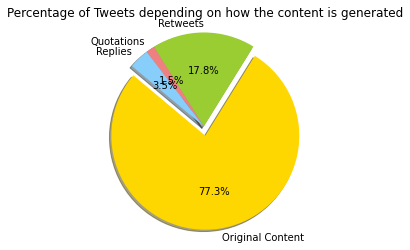

In [42]:
plotTweetTypes(alt_tweets)

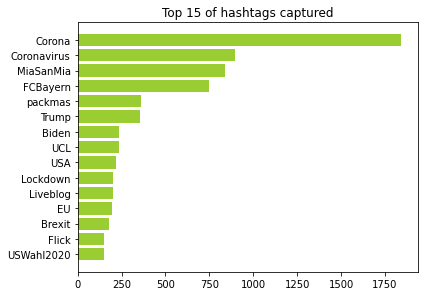

In [43]:
plotHashtags(alt_tweets)

In [44]:
# Plot Hashtags
covid_tweet_dates = covidHashtags(alt_tweets)
num_covid_tweets = np.sum(covid_tweet_dates[:,1])

print("There are " + str(num_covid_tweets) + " of " + str(num_alt_tweets) + " tweets with the hastags related to COVID-19.")

There are 3039 of 39885 tweets with the hastags related to COVID-19.


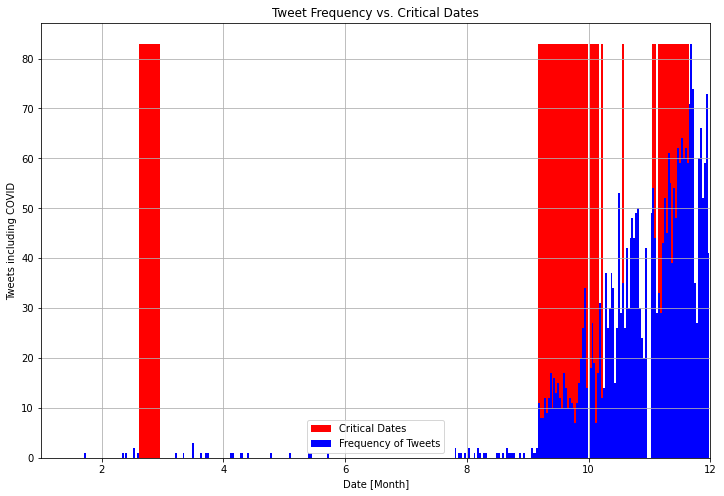

In [45]:
data = compareData(critical_dates, covid_tweet_dates, 'Tweet Frequency vs. Critical Dates', 'Date [Month]', 'Tweets including COVID')

In [46]:
num_crit_tweets = int(np.sum(data[1][data[2]]))

print("Out of the " + str(num_covid_tweets) + " tweets with the COVID-19 Hashtags, " + str(num_crit_tweets) + " tweets (" + str(round(100*num_crit_tweets/num_covid_tweets,2)) + " percent) are within criticial dates.\nCritical dates make up " + str(round(100*np.sum(data[2])/len(data[2]),2)) + " percent of days of the year.")

Out of the 3039 tweets with the COVID-19 Hashtags, 1412 tweets (46.46 percent) are within criticial dates.
Critical dates make up 17.61 percent of days of the year.


Sadly, this method is also inconclusive, since the data is scewed to more recent dates. Here we can clearly see the drawbacks of collecting tweets with this method. To do a better analysis, data from all people in germany using the hashtags would have to be collected with a paid account or streamed over a long period of time.